# Set Card Game: Relational Neural Network Experiments

## Set Up

In [1]:
import os
import itertools
import numpy as np
import sklearn.model_selection
import sklearn.metrics

import wandb

import tensorflow as tf


# %load_ext autoreload
# %autoreload 2
from relational_neural_networks import *
from utils import *

### Generate dataset for set card game

In [2]:
colors = (0, 1, 2)
shapes = (0, 1, 2)
fills = (0, 1, 2)
nums = (0, 1, 2)

color_dict = {0: 'red', 1: 'green', 2: 'blue'}
shape_dict = {0: 'bar', 1: 'squiggle', 2: 'diamond'}
fill_dict = {0: 'filled', 1: 'striped', 2: 'empty'}
num_dict = {0: '1', 1: '2', 2: '3'}

In [3]:
# space of possible 'entities' / cards: product space of color, shape, and fill attributes
entity_space = list(itertools.product(colors, shapes, fills, nums))
print('# of possible entities: ', len(entity_space))

# of possible entities:  81


In [4]:
# space of triplets: all possible combinations of triplets of the 27 cards
triplet_space = list(itertools.permutations(entity_space, 3))
# triplet_space = list(itertools.combinations(entity_space, 3))
# triplet_space = list(itertools.product(entity_space, repeat=3))
print('size of triplet space: ', len(triplet_space))

size of triplet space:  511920


In [5]:
# create a dictionary mapping each entity to a one_hot encoding of its attributes (e.g.: is_red, is_diamond, etc.)
entity_encodings = {}

for entity in entity_space:
    c, s, f, n = entity
    encoding = [0]*4*3
    encoding[c] = 1
    encoding[s + 3] = 1
    encoding[f + 6] = 1
    encoding[n + 9] = 1
    entity_encodings[entity] = tuple(encoding)

# define encoding function
def encode_entity(entity):
    return entity_encodings[entity]

def encode_triplet(triplet):
    return tuple(encode_entity(entity) for entity in triplet)

In [6]:
def classify_triplet(triplet):

    for attr in (0, 1, 2, 3): # check each attribute (color, shape, fill, num)
        attr_vals = [entity[attr] for entity in triplet]
        all_same = len(set(attr_vals)) == 1
        all_different = len(set(attr_vals)) == 3
        if not (all_same or all_different):
            return False

    return True

class_names = ['non-set', 'set']

In [7]:
X = triplet_space
y = np.array([classify_triplet(triplet) for triplet in triplet_space])

In [8]:
print('proportion of sets in triplet space: ', np.mean(y))

proportion of sets in triplet space:  0.012658227848101266


In [9]:
# samples of sets:
def get_entity_desc(entity):
    c, s, f, n = entity
    c = color_dict[c]
    s = shape_dict[s]
    f = fill_dict[f]
    n = num_dict[n]
    return (c, s, f, n)


print('samples of sets:')
sets = [x_ for x_, y_ in zip(X,y) if y_]
sets_sample = [sets[i] for i in np.random.choice(len(sets), size=5)]
for set_ in sets_sample:
    print(tuple(get_entity_desc(entity) for entity in set_))

# samples of non-sets:
print()
print('samples of non-sets:')
non_sets = [x_ for x_, y_ in zip(X,y) if not y_]
nonsets_sample = [non_sets[i] for i in np.random.choice(len(non_sets), size=5)]
for nonset_ in nonsets_sample:
    print(tuple(get_entity_desc(entity) for entity in nonset_))

samples of sets:
(('green', 'squiggle', 'striped', '3'), ('blue', 'bar', 'empty', '1'), ('red', 'diamond', 'filled', '2'))
(('red', 'diamond', 'filled', '3'), ('red', 'bar', 'striped', '1'), ('red', 'squiggle', 'empty', '2'))
(('green', 'diamond', 'striped', '2'), ('blue', 'squiggle', 'empty', '1'), ('red', 'bar', 'filled', '3'))
(('red', 'bar', 'striped', '1'), ('green', 'diamond', 'empty', '2'), ('blue', 'squiggle', 'filled', '3'))
(('green', 'diamond', 'striped', '2'), ('green', 'squiggle', 'filled', '1'), ('green', 'bar', 'empty', '3'))

samples of non-sets:
(('green', 'squiggle', 'striped', '2'), ('green', 'squiggle', 'filled', '1'), ('blue', 'diamond', 'striped', '2'))
(('red', 'squiggle', 'empty', '3'), ('red', 'diamond', 'filled', '2'), ('blue', 'diamond', 'striped', '1'))
(('green', 'bar', 'empty', '3'), ('red', 'squiggle', 'empty', '2'), ('green', 'diamond', 'empty', '2'))
(('blue', 'bar', 'striped', '3'), ('green', 'diamond', 'filled', '2'), ('green', 'diamond', 'striped', '

In [10]:
X_enc = np.array([encode_triplet(triplet) for triplet in X])
X_enc.shape # (n_samples, n_entities, dim_encoding)

(511920, 3, 12)

In [11]:
# the data is highly imbalanced; create a balanced dataset by random undersampling
import imblearn.under_sampling
resampler = imblearn.under_sampling.RandomUnderSampler()
res_idx, y_res = resampler.fit_resample(np.array(range(len(y))).reshape(-1,1), y)
X_enc_res = np.array(X_enc) [np.squeeze(res_idx)]

# split training, validation, and testing sets
test_size = 0.4
val_size = 0.1

train_idx, test_idx = sklearn.model_selection.train_test_split(range(len(y_res)), test_size=test_size, stratify=y_res)
X_test = [X_enc_res[i] for i in test_idx]
y_test = [int(y_res[i]) for i in test_idx]

y_train = [int(y_res[i]) for i in train_idx]

train_idx, val_idx = sklearn.model_selection.train_test_split(train_idx, test_size=val_size/(1-test_size), stratify=y_train)

X_train = [X_enc_res[i] for i in train_idx]
y_train = [int(y_res[i]) for i in train_idx]
X_val = [X_enc_res[i] for i in val_idx]
y_val = [int(y_res[i]) for i in val_idx]

y_train = tf.one_hot(y_train, 2)
y_val = tf.one_hot(y_val, 2)
y_test = tf.one_hot(y_test, 2)

# create tensorflow datasets
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

2022-10-30 17:39:38.431760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:39:38.598842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:39:38.599840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:39:38.603814: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
print(f'# of training samples:   {len(y_train): 5}')
print(f'# of validation samples: {len(y_val): 5}')
print(f'# of testing samples:    {len(y_test): 5}')

# of training samples:    6479
# of validation samples:  1297
# of testing samples:     5184


## Models

In [13]:
# set up W&B logging
%load_ext dotenv
%dotenv

%env "WANDB_NOTEBOOK_NAME" "rmts-group-experiments.ipynb"

import wandb
wandb.login(key=os.environ['WANDB_API_KEY'])

env: "WANDB_NOTEBOOK_NAME"="set-experiments.ipynb"


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
# define common components across models

def create_callbacks():
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbCallback(
            monitor="val_loss", log_weights=True, log_gradients=True, save_model=True, save_graph=True,
            training_data=train_ds, validation_data=val_ds,
            labels=['non-set', 'set'], predictions=64, compute_flops=True)
        ]
    return callbacks

metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=0.01)

fit_kwargs = {'epochs': 100, 'batch_size': 128, 'shuffle': True}

def eval_metrics(model):
    
    print('test set')
    pred_proba_test = model.predict(test_ds)
    pred_test = np.argmax(pred_proba_test, axis=1)
    print(sklearn.metrics.classification_report(y_test[:,1], pred_test))
    
    return pred_proba_test, pred_test

def log_to_wandb(y_test, pred_proba_test, pred_test):
    # log test-set metrics to W&B
    y_test = np.array(y_test[:,1])
    wandb.log({"pr": wandb.plot.pr_curve(y_test, pred_proba_test, class_names)})
    wandb.log({"roc": wandb.plot.roc_curve(y_test, pred_proba_test, labels=class_names)})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(y_true=y_test, preds=pred_test, class_names=class_names)})

In [15]:
n_entities, base_encoding_dim = X_enc.shape[1:]

### Non-relational model: MLP

In [16]:
input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

x = tf.keras.layers.Flatten(name='flatten')(input_)

x = tf.keras.layers.Dense(32, activation='relu', name='dense1')(x)
x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

non_rel_mlp = tf.keras.Model(input_, x, name='non_rel_mlp')
non_rel_mlp.compile(loss=loss, optimizer=opt, metrics=metrics)
non_rel_mlp.summary()

Model: "non_rel_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense1 (Dense)               (None, 32)                1184      
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


In [17]:
run = wandb.init(project='RelNN', group='Non-Relational MLP', save_code=True)
history = non_rel_mlp.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-10-30 17:40:00.976206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:40:00.976838: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-30 17:40:00.977030: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-30 17:40:00.977838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

Epoch 1/100


2022-10-30 17:40:02.392961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


51/51 [==============================] - 4s 25ms/step - loss: 0.7491 - acc: 0.5027 - precision: 0.5105 - recall: 0.1275 - auc: 0.5041 - val_loss: 0.7163 - val_acc: 0.4965 - val_precision: 0.4940 - val_recall: 0.2558 - val_auc: 0.4904
Epoch 2/100
51/51 [==============================] - 0s 10ms/step - loss: 0.7085 - acc: 0.4971 - precision: 0.4960 - recall: 0.3652 - auc: 0.5023 - val_loss: 0.7081 - val_acc: 0.4965 - val_precision: 0.4964 - val_recall: 0.4191 - val_auc: 0.4923
Epoch 3/100
51/51 [==============================] - 0s 9ms/step - loss: 0.7046 - acc: 0.5010 - precision: 0.5010 - recall: 0.4680 - auc: 0.5027 - val_loss: 0.7060 - val_acc: 0.4888 - val_precision: 0.4890 - val_recall: 0.4792 - val_auc: 0.4934
Epoch 4/100
51/51 [==============================] - 0s 7ms/step - loss: 0.7029 - acc: 0.4981 - precision: 0.4979 - recall: 0.4869 - auc: 0.5039 - val_loss: 0.7045 - val_acc: 0.4888 - val_precision: 0.4892 - val_recall: 0.4900 - val_auc: 0.4948
Epoch 5/100
51/51 [===========

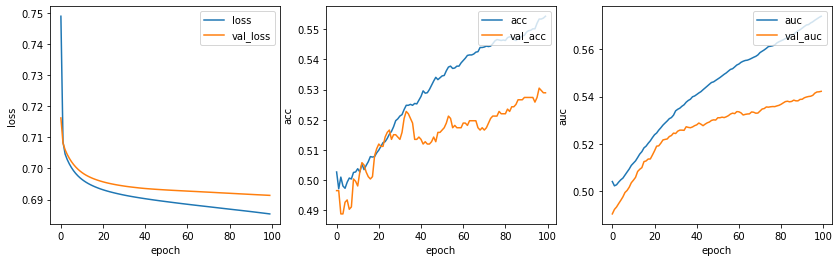

In [18]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [19]:
pred_proba_test, pred_test = eval_metrics(non_rel_mlp)

test set
              precision    recall  f1-score   support

         0.0       0.52      0.48      0.50      2592
         1.0       0.52      0.55      0.53      2592

    accuracy                           0.52      5184
   macro avg       0.52      0.52      0.52      5184
weighted avg       0.52      0.52      0.52      5184



In [20]:
log_to_wandb(y_test, pred_proba_test, pred_test)

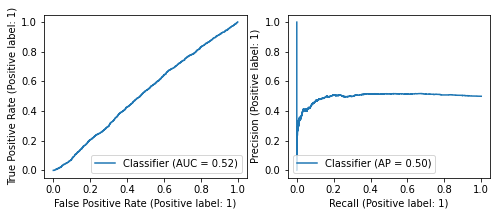

In [21]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

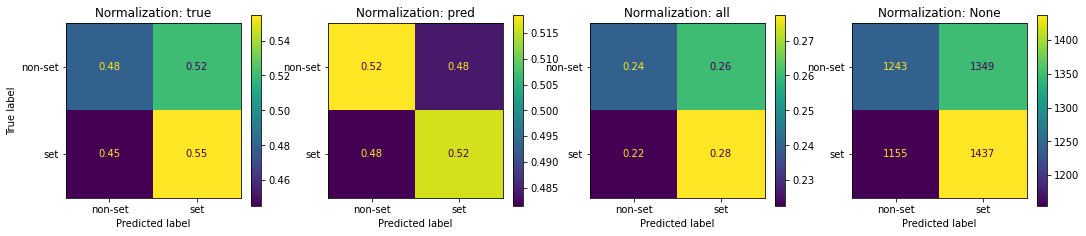

In [22]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [23]:
wandb.finish()

acc,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██
auc,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▂▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██
recall,▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
val_acc,▂▁▂▁▃▄▃▃▅▅▆▅▅▇▆▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
val_auc,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▂▁▂▁▃▄▃▃▅▅▆▅▅▇▆▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇████


### CoRelNet

In [24]:
def create_corelnet_model(n_entities, base_encoding_dim, encoder_constructor, name='CoRelNet'):
    input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

    if encoder_constructor is not None:
        x = EntityEncoder(encoder_constructor, name='encode_entities')(input_)
    else:
        x = input_

    x = RelInnerProduct(name='relation_inner_prod')(x)

    x = tf.keras.layers.Flatten(name='flatten')(x)

    x = tf.keras.layers.Dense(9, activation='relu', name='dense1')(x)
    
    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    corelnet = tf.keras.Model(input_, x, name=name)

    return corelnet

#### CoRelNet: No Encoder

In [25]:
encoder_constructor = None

corelnet = create_corelnet_model(n_entities=3, base_encoding_dim=12, encoder_constructor=encoder_constructor)
corelnet.compile(loss=loss, optimizer=opt, metrics=metrics)
corelnet.summary()

Model: "CoRelNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
relation_inner_prod (RelInne (None, 3, 3)              0         
_________________________________________________________________
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
dense1 (Dense)               (None, 9)                 90        
_________________________________________________________________
output (Dense)               (None, 2)                 20        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [26]:
run = wandb.init(project='RelNN', group='CoRelNet (no encoder)', save_code=True)
history = corelnet.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-30 17:41:53.673556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:41:53.674224: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-30 17:41:53.674453: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-30 17:41:53.675282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:41:53.675899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:41:53.676425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 2s 25ms/step - loss: 0.7272 - acc: 0.4807 - precision: 0.4808 - recall: 0.4820 - auc: 0.4795 - val_loss: 0.7079 - val_acc: 0.4487 - val_precision: 0.4423 - val_recall: 0.3898 - val_auc: 0.4308
Epoch 2/100
51/51 [==============================] - 1s 10ms/step - loss: 0.7012 - acc: 0.4914 - precision: 0.4913 - recall: 0.4887 - auc: 0.4775 - val_loss: 0.7005 - val_acc: 0.4079 - val_precision: 0.3845 - val_recall: 0.3051 - val_auc: 0.4542
Epoch 3/100
51/51 [==============================] - 0s 8ms/step - loss: 0.6971 - acc: 0.4982 - precision: 0.4982 - recall: 0.5045 - auc: 0.4900 - val_loss: 0.6973 - val_acc: 0.2984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4932
Epoch 4/100
51/51 [==============================] - 0s 8ms/step - loss: 0.6947 - acc: 0.4936 - precision: 0.4936 - recall: 0.4986 - auc: 0.5043 - val_loss: 0.6952 - val_acc: 0.4040 - val_precision: 0.3333 - val_recall: 0.1911 - val_auc: 0.5104
Epoch 5/10

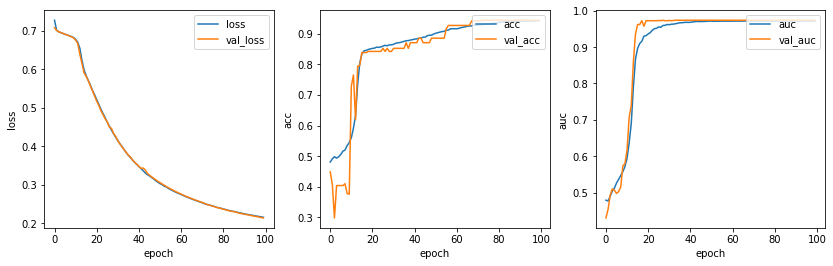

In [27]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [28]:
pred_proba_test, pred_test = eval_metrics(corelnet)

test set
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93      2592
         1.0       0.89      1.00      0.94      2592

    accuracy                           0.94      5184
   macro avg       0.95      0.94      0.94      5184
weighted avg       0.95      0.94      0.94      5184



In [29]:
log_to_wandb(y_test, pred_proba_test, pred_test)

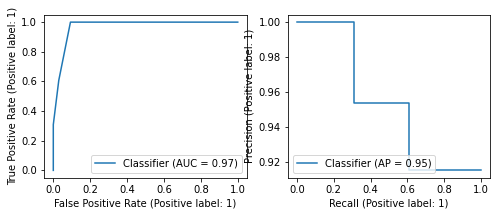

In [30]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

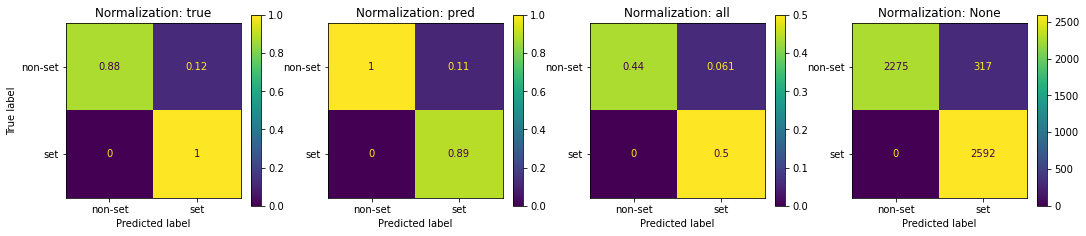

In [31]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [32]:
wandb.finish()

acc,▁▁▁▂▂▃▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
auc,▁▁▂▂▃▄▇▇▇███████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▂▂▃▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
recall,▁▁▁▂▃▄██████████████████████████████████
val_acc,▃▁▂▂▆▄▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_auc,▁▂▂▂▃▅██████████████████████████████████
val_loss,█████▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_precision,▄▁▄▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████


#### CoRelNet: MLP Encoder

In [33]:
encoder_constructor = lambda: MLPEncoder([12], activation='relu')

corelnet = create_corelnet_model(n_entities=3, base_encoding_dim=12, encoder_constructor=encoder_constructor)
corelnet.compile(loss=loss, optimizer=opt, metrics=metrics)
corelnet.summary()

Model: "CoRelNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
encode_entities (EntityEncod (None, 3, 12)             156       
_________________________________________________________________
relation_inner_prod (RelInne (None, 3, 3)              0         
_________________________________________________________________
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
dense1 (Dense)               (None, 9)                 90        
_________________________________________________________________
output (Dense)               (None, 2)                 20        
Total params: 266
Trainable params: 266
Non-trainable params: 0
____________________________________________________________

In [34]:
run = wandb.init(project='RelNN', group='CoRelNet (MLP encoder)', save_code=True)
history = corelnet.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-30 17:43:45.839764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:43:45.840328: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-30 17:43:45.840535: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-30 17:43:45.841241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:43:45.841841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 17:43:45.842358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 9s 162ms/step - loss: 0.7590 - acc: 0.5678 - precision: 0.5499 - recall: 0.7485 - auc: 0.6261 - val_loss: 0.6974 - val_acc: 0.5150 - val_precision: 0.5148 - val_recall: 0.5347 - val_auc: 0.5223


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
2022-10-30 17:44:03.436450: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 2/100
51/51 [==============================] - 8s 149ms/step - loss: 0.7034 - acc: 0.5005 - precision: 0.5006 - recall: 0.4035 - auc: 0.4963 - val_loss: 0.6928 - val_acc: 0.5135 - val_precision: 0.5206 - val_recall: 0.3498 - val_auc: 0.5231


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 3/100
51/51 [==============================] - 4s 86ms/step - loss: 0.6977 - acc: 0.5063 - precision: 0.5102 - recall: 0.3075 - auc: 0.5047 - val_loss: 0.6919 - val_acc: 0.5197 - val_precision: 0.5355 - val_recall: 0.3020 - val_auc: 0.5232


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 4/100
51/51 [==============================] - 5s 95ms/step - loss: 0.6954 - acc: 0.5174 - precision: 0.5327 - recall: 0.2819 - auc: 0.5117 - val_loss: 0.6917 - val_acc: 0.5143 - val_precision: 0.5280 - val_recall: 0.2758 - val_auc: 0.5229


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 5/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6943 - acc: 0.5164 - precision: 0.5320 - recall: 0.2720 - auc: 0.5173 - val_loss: 0.6913 - val_acc: 0.5197 - val_precision: 0.5385 - val_recall: 0.2804 - val_auc: 0.5246


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 6/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6936 - acc: 0.5189 - precision: 0.5367 - recall: 0.2754 - auc: 0.5185 - val_loss: 0.6912 - val_acc: 0.5274 - val_precision: 0.5517 - val_recall: 0.2958 - val_auc: 0.5281


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 7/100
51/51 [==============================] - 5s 99ms/step - loss: 0.6930 - acc: 0.5232 - precision: 0.5443 - recall: 0.2843 - auc: 0.5230 - val_loss: 0.6910 - val_acc: 0.5258 - val_precision: 0.5470 - val_recall: 0.3051 - val_auc: 0.5283


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 8/100
51/51 [==============================] - 4s 88ms/step - loss: 0.6926 - acc: 0.5249 - precision: 0.5463 - recall: 0.2930 - auc: 0.5229 - val_loss: 0.6908 - val_acc: 0.5251 - val_precision: 0.5442 - val_recall: 0.3128 - val_auc: 0.5312


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 9/100
51/51 [==============================] - 5s 101ms/step - loss: 0.6922 - acc: 0.5240 - precision: 0.5433 - recall: 0.3001 - auc: 0.5234 - val_loss: 0.6906 - val_acc: 0.5243 - val_precision: 0.5408 - val_recall: 0.3267 - val_auc: 0.5289


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 10/100
51/51 [==============================] - 4s 78ms/step - loss: 0.6918 - acc: 0.5235 - precision: 0.5418 - recall: 0.3044 - auc: 0.5250 - val_loss: 0.6905 - val_acc: 0.5204 - val_precision: 0.5347 - val_recall: 0.3205 - val_auc: 0.5240


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 11/100
51/51 [==============================] - 4s 85ms/step - loss: 0.6914 - acc: 0.5234 - precision: 0.5411 - recall: 0.3069 - auc: 0.5292 - val_loss: 0.6905 - val_acc: 0.5181 - val_precision: 0.5311 - val_recall: 0.3159 - val_auc: 0.5259


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 12/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6911 - acc: 0.5254 - precision: 0.5447 - recall: 0.3087 - auc: 0.5302 - val_loss: 0.6904 - val_acc: 0.5158 - val_precision: 0.5273 - val_recall: 0.3128 - val_auc: 0.5270


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 13/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6908 - acc: 0.5259 - precision: 0.5457 - recall: 0.3081 - auc: 0.5326 - val_loss: 0.6903 - val_acc: 0.5112 - val_precision: 0.5193 - val_recall: 0.3112 - val_auc: 0.5274


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 14/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6906 - acc: 0.5257 - precision: 0.5449 - recall: 0.3112 - auc: 0.5351 - val_loss: 0.6902 - val_acc: 0.5096 - val_precision: 0.5165 - val_recall: 0.3143 - val_auc: 0.5259


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 15/100
51/51 [==============================] - 4s 81ms/step - loss: 0.6903 - acc: 0.5272 - precision: 0.5468 - recall: 0.3177 - auc: 0.5361 - val_loss: 0.6900 - val_acc: 0.5120 - val_precision: 0.5202 - val_recall: 0.3174 - val_auc: 0.5258


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 16/100
51/51 [==============================] - 4s 81ms/step - loss: 0.6901 - acc: 0.5288 - precision: 0.5487 - recall: 0.3236 - auc: 0.5361 - val_loss: 0.6899 - val_acc: 0.5150 - val_precision: 0.5250 - val_recall: 0.3236 - val_auc: 0.5237


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 17/100
51/51 [==============================] - 4s 88ms/step - loss: 0.6899 - acc: 0.5296 - precision: 0.5498 - recall: 0.3257 - auc: 0.5373 - val_loss: 0.6899 - val_acc: 0.5112 - val_precision: 0.5190 - val_recall: 0.3159 - val_auc: 0.5231


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 18/100
51/51 [==============================] - 4s 88ms/step - loss: 0.6897 - acc: 0.5289 - precision: 0.5489 - recall: 0.3239 - auc: 0.5371 - val_loss: 0.6898 - val_acc: 0.5104 - val_precision: 0.5178 - val_recall: 0.3143 - val_auc: 0.5243


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 19/100
51/51 [==============================] - 5s 90ms/step - loss: 0.6895 - acc: 0.5291 - precision: 0.5492 - recall: 0.3239 - auc: 0.5393 - val_loss: 0.6896 - val_acc: 0.5143 - val_precision: 0.5239 - val_recall: 0.3205 - val_auc: 0.5215


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 20/100
51/51 [==============================] - 5s 89ms/step - loss: 0.6893 - acc: 0.5297 - precision: 0.5498 - recall: 0.3270 - auc: 0.5426 - val_loss: 0.6895 - val_acc: 0.5143 - val_precision: 0.5242 - val_recall: 0.3174 - val_auc: 0.5243


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 21/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6891 - acc: 0.5308 - precision: 0.5517 - recall: 0.3279 - auc: 0.5419 - val_loss: 0.6894 - val_acc: 0.5150 - val_precision: 0.5255 - val_recall: 0.3174 - val_auc: 0.5243


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 22/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6889 - acc: 0.5283 - precision: 0.5477 - recall: 0.3245 - auc: 0.5443 - val_loss: 0.6893 - val_acc: 0.5135 - val_precision: 0.5227 - val_recall: 0.3190 - val_auc: 0.5226


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 23/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6887 - acc: 0.5291 - precision: 0.5487 - recall: 0.3270 - auc: 0.5456 - val_loss: 0.6892 - val_acc: 0.5173 - val_precision: 0.5291 - val_recall: 0.3220 - val_auc: 0.5225


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 24/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6885 - acc: 0.5300 - precision: 0.5505 - recall: 0.3266 - auc: 0.5484 - val_loss: 0.6891 - val_acc: 0.5181 - val_precision: 0.5305 - val_recall: 0.3220 - val_auc: 0.5235


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 25/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6883 - acc: 0.5316 - precision: 0.5528 - recall: 0.3294 - auc: 0.5494 - val_loss: 0.6890 - val_acc: 0.5189 - val_precision: 0.5315 - val_recall: 0.3251 - val_auc: 0.5251


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 26/100
51/51 [==============================] - 4s 81ms/step - loss: 0.6881 - acc: 0.5340 - precision: 0.5566 - recall: 0.3341 - auc: 0.5499 - val_loss: 0.6888 - val_acc: 0.5143 - val_precision: 0.5237 - val_recall: 0.3236 - val_auc: 0.5253


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 27/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6879 - acc: 0.5342 - precision: 0.5570 - recall: 0.3331 - auc: 0.5512 - val_loss: 0.6887 - val_acc: 0.5158 - val_precision: 0.5261 - val_recall: 0.3267 - val_auc: 0.5238


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 28/100
51/51 [==============================] - 5s 89ms/step - loss: 0.6877 - acc: 0.5357 - precision: 0.5600 - recall: 0.3328 - auc: 0.5527 - val_loss: 0.6886 - val_acc: 0.5181 - val_precision: 0.5302 - val_recall: 0.3251 - val_auc: 0.5226


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 29/100
51/51 [==============================] - 5s 88ms/step - loss: 0.6874 - acc: 0.5374 - precision: 0.5635 - recall: 0.3316 - auc: 0.5532 - val_loss: 0.6884 - val_acc: 0.5181 - val_precision: 0.5300 - val_recall: 0.3267 - val_auc: 0.5246


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 30/100
51/51 [==============================] - 5s 92ms/step - loss: 0.6872 - acc: 0.5374 - precision: 0.5632 - recall: 0.3328 - auc: 0.5520 - val_loss: 0.6883 - val_acc: 0.5173 - val_precision: 0.5288 - val_recall: 0.3251 - val_auc: 0.5260


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 31/100
51/51 [==============================] - 5s 100ms/step - loss: 0.6870 - acc: 0.5388 - precision: 0.5656 - recall: 0.3341 - auc: 0.5511 - val_loss: 0.6881 - val_acc: 0.5181 - val_precision: 0.5300 - val_recall: 0.3267 - val_auc: 0.5279


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 32/100
51/51 [==============================] - 5s 92ms/step - loss: 0.6868 - acc: 0.5388 - precision: 0.5654 - recall: 0.3350 - auc: 0.5505 - val_loss: 0.6879 - val_acc: 0.5150 - val_precision: 0.5250 - val_recall: 0.3236 - val_auc: 0.5305


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 33/100
51/51 [==============================] - 5s 100ms/step - loss: 0.6866 - acc: 0.5379 - precision: 0.5640 - recall: 0.3331 - auc: 0.5535 - val_loss: 0.6877 - val_acc: 0.5158 - val_precision: 0.5266 - val_recall: 0.3205 - val_auc: 0.5312


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 34/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6863 - acc: 0.5384 - precision: 0.5653 - recall: 0.3313 - auc: 0.5540 - val_loss: 0.6876 - val_acc: 0.5220 - val_precision: 0.5375 - val_recall: 0.3205 - val_auc: 0.5322


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 35/100
51/51 [==============================] - 4s 86ms/step - loss: 0.6861 - acc: 0.5379 - precision: 0.5652 - recall: 0.3279 - auc: 0.5548 - val_loss: 0.6873 - val_acc: 0.5197 - val_precision: 0.5335 - val_recall: 0.3190 - val_auc: 0.5303


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 36/100
51/51 [==============================] - 4s 81ms/step - loss: 0.6858 - acc: 0.5397 - precision: 0.5689 - recall: 0.3276 - auc: 0.5543 - val_loss: 0.6871 - val_acc: 0.5235 - val_precision: 0.5401 - val_recall: 0.3220 - val_auc: 0.5307


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 37/100
51/51 [==============================] - 4s 86ms/step - loss: 0.6856 - acc: 0.5388 - precision: 0.5671 - recall: 0.3273 - auc: 0.5544 - val_loss: 0.6869 - val_acc: 0.5243 - val_precision: 0.5415 - val_recall: 0.3220 - val_auc: 0.5326


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 38/100
51/51 [==============================] - 5s 95ms/step - loss: 0.6854 - acc: 0.5396 - precision: 0.5685 - recall: 0.3279 - auc: 0.5554 - val_loss: 0.6867 - val_acc: 0.5274 - val_precision: 0.5464 - val_recall: 0.3267 - val_auc: 0.5351


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 39/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6851 - acc: 0.5394 - precision: 0.5682 - recall: 0.3279 - auc: 0.5566 - val_loss: 0.6864 - val_acc: 0.5305 - val_precision: 0.5521 - val_recall: 0.3267 - val_auc: 0.5350


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 40/100
51/51 [==============================] - 5s 94ms/step - loss: 0.6849 - acc: 0.5388 - precision: 0.5671 - recall: 0.3276 - auc: 0.5568 - val_loss: 0.6862 - val_acc: 0.5297 - val_precision: 0.5504 - val_recall: 0.3282 - val_auc: 0.5398


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 41/100
51/51 [==============================] - 5s 88ms/step - loss: 0.6846 - acc: 0.5394 - precision: 0.5679 - recall: 0.3294 - auc: 0.5575 - val_loss: 0.6859 - val_acc: 0.5305 - val_precision: 0.5513 - val_recall: 0.3313 - val_auc: 0.5391


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 42/100
51/51 [==============================] - 5s 91ms/step - loss: 0.6843 - acc: 0.5405 - precision: 0.5694 - recall: 0.3319 - auc: 0.5589 - val_loss: 0.6857 - val_acc: 0.5320 - val_precision: 0.5544 - val_recall: 0.3297 - val_auc: 0.5407


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 43/100
51/51 [==============================] - 5s 95ms/step - loss: 0.6841 - acc: 0.5416 - precision: 0.5713 - recall: 0.3328 - auc: 0.5602 - val_loss: 0.6854 - val_acc: 0.5343 - val_precision: 0.5594 - val_recall: 0.3267 - val_auc: 0.5447


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 44/100
51/51 [==============================] - 4s 85ms/step - loss: 0.6838 - acc: 0.5433 - precision: 0.5741 - recall: 0.3350 - auc: 0.5628 - val_loss: 0.6851 - val_acc: 0.5366 - val_precision: 0.5632 - val_recall: 0.3297 - val_auc: 0.5448


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 45/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6835 - acc: 0.5444 - precision: 0.5756 - recall: 0.3371 - auc: 0.5632 - val_loss: 0.6849 - val_acc: 0.5397 - val_precision: 0.5681 - val_recall: 0.3344 - val_auc: 0.5455


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 46/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6832 - acc: 0.5458 - precision: 0.5786 - recall: 0.3362 - auc: 0.5631 - val_loss: 0.6846 - val_acc: 0.5420 - val_precision: 0.5726 - val_recall: 0.3344 - val_auc: 0.5463


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 47/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6829 - acc: 0.5455 - precision: 0.5780 - recall: 0.3362 - auc: 0.5644 - val_loss: 0.6843 - val_acc: 0.5428 - val_precision: 0.5737 - val_recall: 0.3359 - val_auc: 0.5489


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 48/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6826 - acc: 0.5459 - precision: 0.5781 - recall: 0.3393 - auc: 0.5648 - val_loss: 0.6840 - val_acc: 0.5428 - val_precision: 0.5725 - val_recall: 0.3405 - val_auc: 0.5517


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 49/100
51/51 [==============================] - 4s 81ms/step - loss: 0.6822 - acc: 0.5484 - precision: 0.5821 - recall: 0.3427 - auc: 0.5662 - val_loss: 0.6837 - val_acc: 0.5451 - val_precision: 0.5770 - val_recall: 0.3405 - val_auc: 0.5533


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 50/100
51/51 [==============================] - 4s 79ms/step - loss: 0.6819 - acc: 0.5493 - precision: 0.5849 - recall: 0.3393 - auc: 0.5671 - val_loss: 0.6834 - val_acc: 0.5466 - val_precision: 0.5796 - val_recall: 0.3421 - val_auc: 0.5551


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 51/100
51/51 [==============================] - 5s 91ms/step - loss: 0.6816 - acc: 0.5516 - precision: 0.5895 - recall: 0.3396 - auc: 0.5669 - val_loss: 0.6831 - val_acc: 0.5474 - val_precision: 0.5824 - val_recall: 0.3374 - val_auc: 0.5546


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 52/100
51/51 [==============================] - 5s 90ms/step - loss: 0.6812 - acc: 0.5530 - precision: 0.5931 - recall: 0.3374 - auc: 0.5699 - val_loss: 0.6828 - val_acc: 0.5474 - val_precision: 0.5820 - val_recall: 0.3390 - val_auc: 0.5563


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 53/100
51/51 [==============================] - 4s 88ms/step - loss: 0.6808 - acc: 0.5546 - precision: 0.5949 - recall: 0.3415 - auc: 0.5695 - val_loss: 0.6824 - val_acc: 0.5482 - val_precision: 0.5822 - val_recall: 0.3436 - val_auc: 0.5572


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 54/100
51/51 [==============================] - 5s 93ms/step - loss: 0.6805 - acc: 0.5549 - precision: 0.5953 - recall: 0.3424 - auc: 0.5710 - val_loss: 0.6821 - val_acc: 0.5490 - val_precision: 0.5829 - val_recall: 0.3467 - val_auc: 0.5574


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 55/100
51/51 [==============================] - 5s 92ms/step - loss: 0.6801 - acc: 0.5569 - precision: 0.5994 - recall: 0.3427 - auc: 0.5715 - val_loss: 0.6818 - val_acc: 0.5520 - val_precision: 0.5895 - val_recall: 0.3451 - val_auc: 0.5605


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 56/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6797 - acc: 0.5580 - precision: 0.6015 - recall: 0.3430 - auc: 0.5728 - val_loss: 0.6815 - val_acc: 0.5497 - val_precision: 0.5867 - val_recall: 0.3390 - val_auc: 0.5616


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 57/100
51/51 [==============================] - 4s 86ms/step - loss: 0.6793 - acc: 0.5584 - precision: 0.6023 - recall: 0.3436 - auc: 0.5748 - val_loss: 0.6811 - val_acc: 0.5505 - val_precision: 0.5878 - val_recall: 0.3405 - val_auc: 0.5644


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 58/100
51/51 [==============================] - 5s 94ms/step - loss: 0.6789 - acc: 0.5584 - precision: 0.6017 - recall: 0.3452 - auc: 0.5755 - val_loss: 0.6808 - val_acc: 0.5505 - val_precision: 0.5887 - val_recall: 0.3374 - val_auc: 0.5640


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 59/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6785 - acc: 0.5592 - precision: 0.6021 - recall: 0.3486 - auc: 0.5760 - val_loss: 0.6804 - val_acc: 0.5544 - val_precision: 0.5947 - val_recall: 0.3436 - val_auc: 0.5675


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 60/100
51/51 [==============================] - 4s 87ms/step - loss: 0.6780 - acc: 0.5592 - precision: 0.6017 - recall: 0.3498 - auc: 0.5779 - val_loss: 0.6800 - val_acc: 0.5544 - val_precision: 0.5937 - val_recall: 0.3467 - val_auc: 0.5678


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 61/100
51/51 [==============================] - 5s 93ms/step - loss: 0.6776 - acc: 0.5595 - precision: 0.6027 - recall: 0.3489 - auc: 0.5791 - val_loss: 0.6797 - val_acc: 0.5567 - val_precision: 0.5979 - val_recall: 0.3482 - val_auc: 0.5680


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 62/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6771 - acc: 0.5597 - precision: 0.6038 - recall: 0.3467 - auc: 0.5795 - val_loss: 0.6793 - val_acc: 0.5544 - val_precision: 0.5942 - val_recall: 0.3451 - val_auc: 0.5680


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 63/100
51/51 [==============================] - 5s 97ms/step - loss: 0.6767 - acc: 0.5601 - precision: 0.6037 - recall: 0.3495 - auc: 0.5799 - val_loss: 0.6790 - val_acc: 0.5567 - val_precision: 0.5995 - val_recall: 0.3436 - val_auc: 0.5672


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 64/100
51/51 [==============================] - 4s 88ms/step - loss: 0.6762 - acc: 0.5618 - precision: 0.6066 - recall: 0.3513 - auc: 0.5815 - val_loss: 0.6786 - val_acc: 0.5598 - val_precision: 0.6048 - val_recall: 0.3467 - val_auc: 0.5685


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 65/100
51/51 [==============================] - 5s 91ms/step - loss: 0.6757 - acc: 0.5620 - precision: 0.6066 - recall: 0.3523 - auc: 0.5831 - val_loss: 0.6783 - val_acc: 0.5605 - val_precision: 0.6065 - val_recall: 0.3467 - val_auc: 0.5690


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 66/100
51/51 [==============================] - 4s 85ms/step - loss: 0.6752 - acc: 0.5624 - precision: 0.6077 - recall: 0.3520 - auc: 0.5848 - val_loss: 0.6779 - val_acc: 0.5598 - val_precision: 0.6043 - val_recall: 0.3482 - val_auc: 0.5700


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 67/100
51/51 [==============================] - 4s 87ms/step - loss: 0.6746 - acc: 0.5635 - precision: 0.6096 - recall: 0.3529 - auc: 0.5858 - val_loss: 0.6774 - val_acc: 0.5621 - val_precision: 0.6086 - val_recall: 0.3498 - val_auc: 0.5708


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 68/100
51/51 [==============================] - 5s 99ms/step - loss: 0.6741 - acc: 0.5647 - precision: 0.6111 - recall: 0.3557 - auc: 0.5895 - val_loss: 0.6770 - val_acc: 0.5613 - val_precision: 0.6058 - val_recall: 0.3529 - val_auc: 0.5707


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 69/100
51/51 [==============================] - 4s 86ms/step - loss: 0.6735 - acc: 0.5655 - precision: 0.6116 - recall: 0.3588 - auc: 0.5907 - val_loss: 0.6766 - val_acc: 0.5621 - val_precision: 0.6069 - val_recall: 0.3544 - val_auc: 0.5722


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 70/100
51/51 [==============================] - 4s 87ms/step - loss: 0.6729 - acc: 0.5675 - precision: 0.6158 - recall: 0.3588 - auc: 0.5913 - val_loss: 0.6762 - val_acc: 0.5613 - val_precision: 0.6053 - val_recall: 0.3544 - val_auc: 0.5735


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 71/100
51/51 [==============================] - 4s 85ms/step - loss: 0.6723 - acc: 0.5681 - precision: 0.6159 - recall: 0.3618 - auc: 0.5928 - val_loss: 0.6757 - val_acc: 0.5621 - val_precision: 0.6074 - val_recall: 0.3529 - val_auc: 0.5758


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 72/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6717 - acc: 0.5686 - precision: 0.6162 - recall: 0.3634 - auc: 0.5949 - val_loss: 0.6752 - val_acc: 0.5613 - val_precision: 0.6064 - val_recall: 0.3513 - val_auc: 0.5763


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 73/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6710 - acc: 0.5700 - precision: 0.6183 - recall: 0.3655 - auc: 0.5963 - val_loss: 0.6747 - val_acc: 0.5628 - val_precision: 0.6073 - val_recall: 0.3575 - val_auc: 0.5779


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 74/100
51/51 [==============================] - 5s 94ms/step - loss: 0.6703 - acc: 0.5714 - precision: 0.6208 - recall: 0.3665 - auc: 0.5976 - val_loss: 0.6741 - val_acc: 0.5636 - val_precision: 0.6084 - val_recall: 0.3590 - val_auc: 0.5799


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 75/100
51/51 [==============================] - 4s 86ms/step - loss: 0.6696 - acc: 0.5718 - precision: 0.6215 - recall: 0.3671 - auc: 0.5991 - val_loss: 0.6735 - val_acc: 0.5621 - val_precision: 0.6057 - val_recall: 0.3575 - val_auc: 0.5799


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 76/100
51/51 [==============================] - 4s 88ms/step - loss: 0.6688 - acc: 0.5717 - precision: 0.6208 - recall: 0.3680 - auc: 0.6007 - val_loss: 0.6729 - val_acc: 0.5621 - val_precision: 0.6052 - val_recall: 0.3590 - val_auc: 0.5822


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 77/100
51/51 [==============================] - 5s 96ms/step - loss: 0.6680 - acc: 0.5735 - precision: 0.6241 - recall: 0.3696 - auc: 0.6029 - val_loss: 0.6721 - val_acc: 0.5675 - val_precision: 0.6128 - val_recall: 0.3683 - val_auc: 0.5845


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 78/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6672 - acc: 0.5748 - precision: 0.6258 - recall: 0.3717 - auc: 0.6050 - val_loss: 0.6713 - val_acc: 0.5698 - val_precision: 0.6164 - val_recall: 0.3713 - val_auc: 0.5877


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 79/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6663 - acc: 0.5766 - precision: 0.6284 - recall: 0.3748 - auc: 0.6065 - val_loss: 0.6704 - val_acc: 0.5705 - val_precision: 0.6179 - val_recall: 0.3713 - val_auc: 0.5920


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 80/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6653 - acc: 0.5779 - precision: 0.6302 - recall: 0.3767 - auc: 0.6087 - val_loss: 0.6696 - val_acc: 0.5736 - val_precision: 0.6224 - val_recall: 0.3760 - val_auc: 0.5957


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 81/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6644 - acc: 0.5791 - precision: 0.6322 - recall: 0.3779 - auc: 0.6111 - val_loss: 0.6687 - val_acc: 0.5729 - val_precision: 0.6196 - val_recall: 0.3790 - val_auc: 0.5986


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 82/100
51/51 [==============================] - 5s 89ms/step - loss: 0.6633 - acc: 0.5808 - precision: 0.6354 - recall: 0.3788 - auc: 0.6153 - val_loss: 0.6677 - val_acc: 0.5775 - val_precision: 0.6272 - val_recall: 0.3837 - val_auc: 0.6001


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 83/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6622 - acc: 0.5831 - precision: 0.6404 - recall: 0.3788 - auc: 0.6162 - val_loss: 0.6666 - val_acc: 0.5813 - val_precision: 0.6345 - val_recall: 0.3852 - val_auc: 0.6044


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 84/100
51/51 [==============================] - 5s 104ms/step - loss: 0.6609 - acc: 0.5851 - precision: 0.6440 - recall: 0.3804 - auc: 0.6193 - val_loss: 0.6654 - val_acc: 0.5837 - val_precision: 0.6380 - val_recall: 0.3883 - val_auc: 0.6092


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 85/100
51/51 [==============================] - 5s 93ms/step - loss: 0.6597 - acc: 0.5873 - precision: 0.6477 - recall: 0.3825 - auc: 0.6215 - val_loss: 0.6640 - val_acc: 0.5844 - val_precision: 0.6382 - val_recall: 0.3914 - val_auc: 0.6112


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 86/100
51/51 [==============================] - 5s 99ms/step - loss: 0.6583 - acc: 0.5887 - precision: 0.6501 - recall: 0.3838 - auc: 0.6242 - val_loss: 0.6625 - val_acc: 0.5883 - val_precision: 0.6441 - val_recall: 0.3960 - val_auc: 0.6150


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 87/100
51/51 [==============================] - 5s 93ms/step - loss: 0.6569 - acc: 0.5916 - precision: 0.6563 - recall: 0.3844 - auc: 0.6266 - val_loss: 0.6609 - val_acc: 0.5914 - val_precision: 0.6491 - val_recall: 0.3991 - val_auc: 0.6179


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 88/100
51/51 [==============================] - 5s 103ms/step - loss: 0.6553 - acc: 0.5941 - precision: 0.6593 - recall: 0.3890 - auc: 0.6304 - val_loss: 0.6592 - val_acc: 0.5929 - val_precision: 0.6524 - val_recall: 0.3991 - val_auc: 0.6236


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 89/100
51/51 [==============================] - 4s 83ms/step - loss: 0.6537 - acc: 0.5958 - precision: 0.6623 - recall: 0.3906 - auc: 0.6332 - val_loss: 0.6573 - val_acc: 0.5960 - val_precision: 0.6566 - val_recall: 0.4037 - val_auc: 0.6301


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 90/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6519 - acc: 0.5985 - precision: 0.6670 - recall: 0.3933 - auc: 0.6355 - val_loss: 0.6552 - val_acc: 0.5991 - val_precision: 0.6608 - val_recall: 0.4083 - val_auc: 0.6369


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 91/100
51/51 [==============================] - 5s 93ms/step - loss: 0.6500 - acc: 0.6024 - precision: 0.6735 - recall: 0.3973 - auc: 0.6415 - val_loss: 0.6530 - val_acc: 0.6045 - val_precision: 0.6700 - val_recall: 0.4129 - val_auc: 0.6386


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 92/100
51/51 [==============================] - 4s 86ms/step - loss: 0.6479 - acc: 0.6046 - precision: 0.6766 - recall: 0.4004 - auc: 0.6463 - val_loss: 0.6506 - val_acc: 0.6076 - val_precision: 0.6716 - val_recall: 0.4222 - val_auc: 0.6424


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 93/100
51/51 [==============================] - 5s 93ms/step - loss: 0.6458 - acc: 0.6053 - precision: 0.6776 - recall: 0.4017 - auc: 0.6496 - val_loss: 0.6481 - val_acc: 0.6130 - val_precision: 0.6797 - val_recall: 0.4284 - val_auc: 0.6472


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 94/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6434 - acc: 0.6080 - precision: 0.6816 - recall: 0.4051 - auc: 0.6541 - val_loss: 0.6453 - val_acc: 0.6168 - val_precision: 0.6863 - val_recall: 0.4314 - val_auc: 0.6523


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 95/100
51/51 [==============================] - 5s 91ms/step - loss: 0.6408 - acc: 0.6109 - precision: 0.6874 - recall: 0.4066 - auc: 0.6594 - val_loss: 0.6423 - val_acc: 0.6230 - val_precision: 0.6942 - val_recall: 0.4407 - val_auc: 0.6589


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 96/100
51/51 [==============================] - 5s 99ms/step - loss: 0.6382 - acc: 0.6155 - precision: 0.6942 - recall: 0.4128 - auc: 0.6639 - val_loss: 0.6392 - val_acc: 0.6245 - val_precision: 0.6947 - val_recall: 0.4453 - val_auc: 0.6660


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 97/100
51/51 [==============================] - 5s 92ms/step - loss: 0.6354 - acc: 0.6174 - precision: 0.6953 - recall: 0.4177 - auc: 0.6685 - val_loss: 0.6359 - val_acc: 0.6276 - val_precision: 0.7005 - val_recall: 0.4468 - val_auc: 0.6716


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 98/100
51/51 [==============================] - 5s 94ms/step - loss: 0.6324 - acc: 0.6222 - precision: 0.7031 - recall: 0.4227 - auc: 0.6717 - val_loss: 0.6322 - val_acc: 0.6284 - val_precision: 0.7002 - val_recall: 0.4499 - val_auc: 0.6748


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 99/100
51/51 [==============================] - 5s 89ms/step - loss: 0.6293 - acc: 0.6253 - precision: 0.7078 - recall: 0.4264 - auc: 0.6772 - val_loss: 0.6286 - val_acc: 0.6291 - val_precision: 0.7029 - val_recall: 0.4484 - val_auc: 0.6827


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


Epoch 100/100
51/51 [==============================] - 5s 96ms/step - loss: 0.6260 - acc: 0.6293 - precision: 0.7138 - recall: 0.4313 - auc: 0.6820 - val_loss: 0.6247 - val_acc: 0.6369 - val_precision: 0.7119 - val_recall: 0.4607 - val_auc: 0.6890


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_174328-2vk1dcbr/files/model-best)... Done. 0.1s


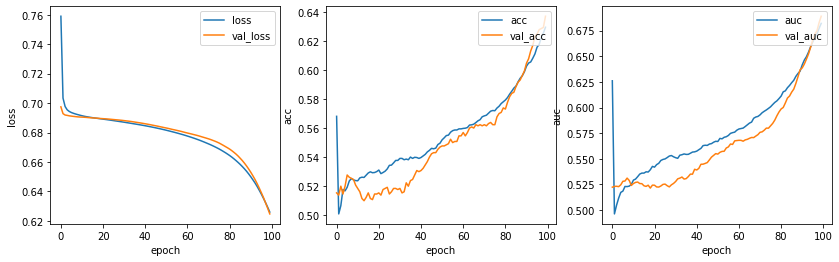

In [35]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [36]:
pred_proba_test, pred_test = eval_metrics(corelnet)

test set
              precision    recall  f1-score   support

         0.0       0.59      0.82      0.69      2592
         1.0       0.71      0.42      0.53      2592

    accuracy                           0.62      5184
   macro avg       0.65      0.62      0.61      5184
weighted avg       0.65      0.62      0.61      5184



In [37]:
log_to_wandb(y_test, pred_proba_test, pred_test)

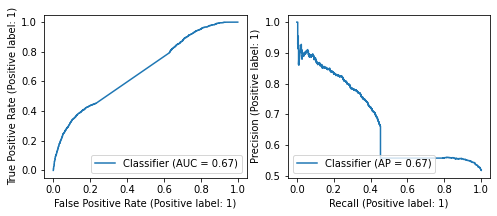

In [38]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

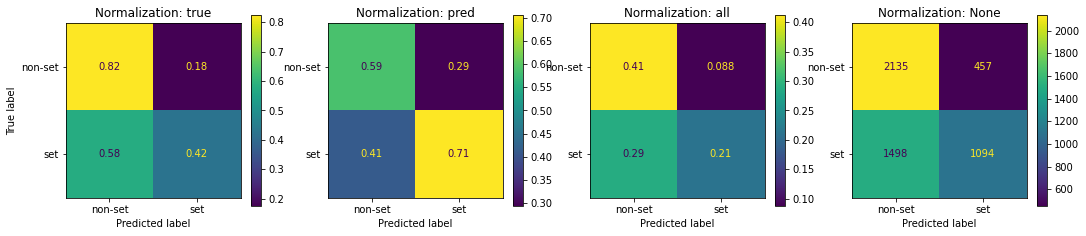

In [39]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [40]:
wandb.finish()

acc,▅▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇█
auc,▆▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▂▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇█
recall,█▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃
val_acc,▁▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▇▇█
val_auc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▆▆▆▇█
val_loss,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▄▄▃▃▂▁
val_precision,▁▂▂▂▂▁▁▁▁▂▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▇▇██


## Relational Neural Network (RelNN) [our model]

#### RelNN: Linear Projection Encoders with fixed good initialization of projection spaces

In [41]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [lambda: tf.keras.layers.Dense(3, activation=None, use_bias=False)]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')
# rel_layer.trainable = False

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')

In [42]:
# linear maps extract 1-hot 3-d vecs for each of 4 attrs
A1 = np.array([[1, 0, 0]+[0]*9, [0, 1, 0] + [0]*9, [0, 0, 1] + [0]*9]).astype(float)
A2 = np.roll(A1, shift=3)
A3 = np.roll(A1, shift=6)
A4 = np.roll(A1, shift=9)

# fix entity encoders
for entity_encoder, A in zip(rel_layer.entity_encoders, (A1, A2, A3, A4)):
    entity_encoder.encoder.set_weights([A.T])
    entity_encoder.trainable = False

In [43]:
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           144       
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 770
Trainable params: 626
Non-trainable params: 144
_________________________________________________________________


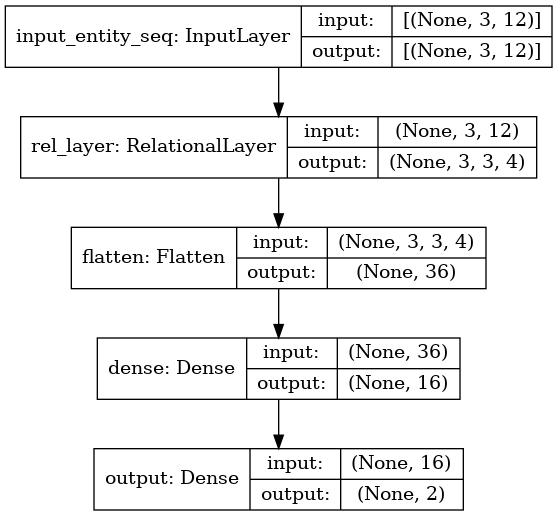

In [44]:
tf.keras.utils.plot_model(relnn, to_file='relnn_architecture.png', expand_nested=True, show_shapes=True)

In [45]:
relnn.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=metrics
    )

In [46]:
run = wandb.init(project='RelNN', group='RelNN (Attr Linear Map, fixed)', save_code=True)
history = relnn.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-30 18:04:37.790019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 18:04:37.790591: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-30 18:04:37.790807: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-30 18:04:37.791581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 18:04:37.792193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 18:04:37.792757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 18s 284ms/step - loss: 0.4791 - acc: 0.7978 - precision: 0.8110 - recall: 0.7767 - auc: 0.8860 - val_loss: 0.2452 - val_acc: 0.9584 - val_precision: 0.9232 - val_recall: 1.0000 - val_auc: 0.9936


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 2/100
51/51 [==============================] - 9s 168ms/step - loss: 0.1206 - acc: 0.9846 - precision: 0.9701 - recall: 1.0000 - auc: 0.9997 - val_loss: 0.0586 - val_acc: 0.9938 - val_precision: 0.9878 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 3/100
51/51 [==============================] - 8s 156ms/step - loss: 0.0369 - acc: 0.9989 - precision: 0.9978 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0272 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 4/100
51/51 [==============================] - 9s 171ms/step - loss: 0.0186 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0160 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 5/100
51/51 [==============================] - 9s 172ms/step - loss: 0.0106 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0094 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 6/100
51/51 [==============================] - 9s 181ms/step - loss: 0.0067 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 7/100
51/51 [==============================] - 8s 160ms/step - loss: 0.0047 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 8/100
51/51 [==============================] - 8s 161ms/step - loss: 0.0036 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 9/100
51/51 [==============================] - 8s 166ms/step - loss: 0.0028 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 10/100
51/51 [==============================] - 9s 175ms/step - loss: 0.0023 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 11/100
51/51 [==============================] - 8s 157ms/step - loss: 0.0019 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 12/100
51/51 [==============================] - 9s 175ms/step - loss: 0.0016 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 13/100
51/51 [==============================] - 9s 169ms/step - loss: 0.0014 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 14/100
51/51 [==============================] - 9s 168ms/step - loss: 0.0012 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 15/100
51/51 [==============================] - 8s 155ms/step - loss: 0.0010 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 16/100
51/51 [==============================] - 9s 169ms/step - loss: 9.0503e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 9.3198e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 17/100
51/51 [==============================] - 8s 153ms/step - loss: 8.0454e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 8.3602e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 18/100
51/51 [==============================] - 9s 170ms/step - loss: 7.2161e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 7.3955e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 19/100
51/51 [==============================] - 8s 162ms/step - loss: 6.4549e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 6.6973e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 20/100
51/51 [==============================] - 9s 166ms/step - loss: 5.8145e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 6.0231e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 21/100
51/51 [==============================] - 9s 169ms/step - loss: 5.2624e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 5.4764e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 22/100
51/51 [==============================] - 8s 162ms/step - loss: 4.7955e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 4.9990e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 23/100
51/51 [==============================] - 8s 163ms/step - loss: 4.3787e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 4.5894e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 24/100
51/51 [==============================] - 8s 160ms/step - loss: 4.0247e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 4.2082e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 25/100
51/51 [==============================] - 9s 175ms/step - loss: 3.6957e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 3.8625e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 26/100
51/51 [==============================] - 8s 165ms/step - loss: 3.4032e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 3.5788e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 27/100
51/51 [==============================] - 9s 169ms/step - loss: 3.1571e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 3.3045e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 28/100
51/51 [==============================] - 8s 165ms/step - loss: 2.9224e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 3.0780e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 29/100
51/51 [==============================] - 8s 167ms/step - loss: 2.7171e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.8498e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 30/100
51/51 [==============================] - 8s 151ms/step - loss: 2.5275e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.6659e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 31/100
51/51 [==============================] - 8s 160ms/step - loss: 2.3662e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.4789e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 32/100
51/51 [==============================] - 9s 169ms/step - loss: 2.2084e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.3294e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 33/100
51/51 [==============================] - 8s 159ms/step - loss: 2.0698e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.1762e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 34/100
51/51 [==============================] - 8s 155ms/step - loss: 1.9409e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.0457e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 35/100
51/51 [==============================] - 9s 170ms/step - loss: 1.8529e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.0020e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 36/100
51/51 [==============================] - 8s 157ms/step - loss: 1.8324e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9901e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 37/100
51/51 [==============================] - 9s 177ms/step - loss: 1.8212e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9757e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 38/100
51/51 [==============================] - 8s 157ms/step - loss: 1.8088e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9643e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 39/100
51/51 [==============================] - 8s 151ms/step - loss: 1.7971e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9510e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000

Epoch 00039: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 40/100
51/51 [==============================] - 8s 165ms/step - loss: 1.7880e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9464e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 41/100
51/51 [==============================] - 8s 155ms/step - loss: 1.7859e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9451e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 42/100
51/51 [==============================] - 8s 167ms/step - loss: 1.7846e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9437e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 43/100
51/51 [==============================] - 9s 172ms/step - loss: 1.7832e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9423e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 44/100
51/51 [==============================] - 9s 168ms/step - loss: 1.7819e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9407e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000

Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 45/100
51/51 [==============================] - 8s 150ms/step - loss: 1.7809e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9401e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 46/100
51/51 [==============================] - 8s 164ms/step - loss: 1.7806e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9400e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 47/100
51/51 [==============================] - 9s 170ms/step - loss: 1.7804e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9399e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 48/100
51/51 [==============================] - 9s 166ms/step - loss: 1.7803e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9398e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 49/100
51/51 [==============================] - 8s 161ms/step - loss: 1.7801e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000

Epoch 00049: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 50/100
51/51 [==============================] - 9s 168ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 51/100
51/51 [==============================] - 8s 158ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 52/100
51/51 [==============================] - 9s 176ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 53/100
51/51 [==============================] - 9s 168ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 54/100
51/51 [==============================] - 9s 178ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000

Epoch 00054: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
Epoch 55/100
51/51 [==============================] - 8s 151ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 56/100
51/51 [==============================] - 9s 167ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_180420-21znpu7t/files/model-best)... Done. 0.1s


Epoch 57/100
51/51 [==============================] - 8s 162ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 58/100
51/51 [==============================] - 9s 169ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 59/100
51/51 [==============================] - 9s 173ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9395e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000

Epoch 00059: ReduceLROnPlateau reducing learning rate to 9.999998695775504e-09.
Epoch 60/100
51/51 [==============================] - 9s 171ms/step - loss: 1.7800e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

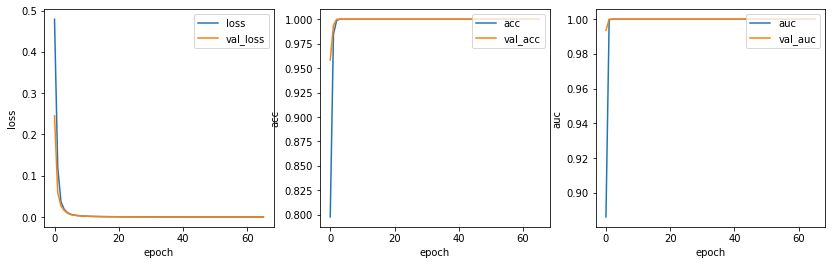

In [47]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [48]:
pred_proba_test, pred_test = eval_metrics(relnn)

test set
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2592
         1.0       1.00      1.00      1.00      2592

    accuracy                           1.00      5184
   macro avg       1.00      1.00      1.00      5184
weighted avg       1.00      1.00      1.00      5184



In [49]:
log_to_wandb(y_test, pred_proba_test, pred_test)

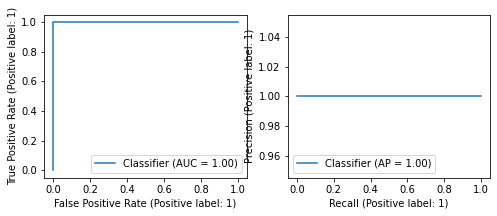

In [50]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

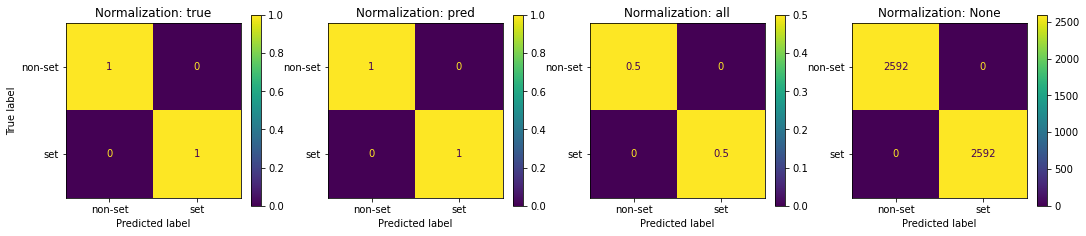

In [51]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [52]:
wandb.finish()

acc,▁▇██████████████████████████████████████
auc,▁███████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████████████████████▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▇██████████████████████████████████████
recall,▁███████████████████████████████████████
val_acc,▁▇██████████████████████████████████████
val_auc,▁███████████████████████████████████████
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▇██████████████████████████████████████


#### RelNN: Linear Projection Encoders with randomly initialized projection spaces

In [53]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [LinearProjectionEncoder]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           48        
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 674
Trainable params: 674
Non-trainable params: 0
_________________________________________________________________


In [54]:
relnn.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=metrics
    )

In [55]:
run = wandb.init(project='RelNN', group='RelNN (Linear Projection)', save_code=True)
history = relnn.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-30 18:30:33.256095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 18:30:33.256631: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-30 18:30:33.256871: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-30 18:30:33.257733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 18:30:33.258349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 18:30:33.258930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 34s 566ms/step - loss: 0.5901 - acc: 0.7342 - precision: 0.7075 - recall: 0.7984 - auc: 0.8296 - val_loss: 0.4099 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8504


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 2/100
51/51 [==============================] - 19s 376ms/step - loss: 0.3802 - acc: 0.8420 - precision: 0.7639 - recall: 0.9898 - auc: 0.8477 - val_loss: 0.3876 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8376


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 3/100
51/51 [==============================] - 18s 353ms/step - loss: 0.3715 - acc: 0.8444 - precision: 0.7640 - recall: 0.9966 - auc: 0.8466 - val_loss: 0.3749 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8255


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 4/100
51/51 [==============================] - 19s 361ms/step - loss: 0.3685 - acc: 0.8453 - precision: 0.7641 - recall: 0.9991 - auc: 0.8460 - val_loss: 0.3665 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8397


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 5/100
51/51 [==============================] - 19s 377ms/step - loss: 0.3643 - acc: 0.8460 - precision: 0.7645 - recall: 1.0000 - auc: 0.8462 - val_loss: 0.3641 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8436


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 6/100
51/51 [==============================] - 19s 364ms/step - loss: 0.3643 - acc: 0.8444 - precision: 0.7640 - recall: 0.9966 - auc: 0.8502 - val_loss: 0.3635 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8543


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 7/100
51/51 [==============================] - 18s 358ms/step - loss: 0.3618 - acc: 0.8458 - precision: 0.7643 - recall: 1.0000 - auc: 0.8517 - val_loss: 0.3613 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8506


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 8/100
51/51 [==============================] - 19s 368ms/step - loss: 0.3600 - acc: 0.8460 - precision: 0.7650 - recall: 0.9988 - auc: 0.8539 - val_loss: 0.3609 - val_acc: 0.8450 - val_precision: 0.7635 - val_recall: 1.0000 - val_auc: 0.8571


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.2s


Epoch 9/100
51/51 [==============================] - 19s 371ms/step - loss: 0.3579 - acc: 0.8474 - precision: 0.7688 - recall: 0.9935 - auc: 0.8617 - val_loss: 0.3407 - val_acc: 0.8612 - val_precision: 0.7849 - val_recall: 0.9954 - val_auc: 0.8871


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 10/100
51/51 [==============================] - 18s 362ms/step - loss: 0.2700 - acc: 0.9069 - precision: 0.8489 - recall: 0.9901 - auc: 0.9328 - val_loss: 0.2461 - val_acc: 0.9144 - val_precision: 0.8587 - val_recall: 0.9923 - val_auc: 0.9383


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 11/100
51/51 [==============================] - 19s 364ms/step - loss: 0.2158 - acc: 0.9344 - precision: 0.8861 - recall: 0.9969 - auc: 0.9475 - val_loss: 0.2131 - val_acc: 0.9337 - val_precision: 0.8830 - val_recall: 1.0000 - val_auc: 0.9429


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 12/100
51/51 [==============================] - 19s 379ms/step - loss: 0.2007 - acc: 0.9400 - precision: 0.8943 - recall: 0.9978 - auc: 0.9508 - val_loss: 0.2091 - val_acc: 0.9375 - val_precision: 0.8890 - val_recall: 1.0000 - val_auc: 0.9425


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 13/100
51/51 [==============================] - 19s 375ms/step - loss: 0.1936 - acc: 0.9432 - precision: 0.8993 - recall: 0.9981 - auc: 0.9513 - val_loss: 0.2056 - val_acc: 0.9391 - val_precision: 0.8915 - val_recall: 1.0000 - val_auc: 0.9426


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 14/100
51/51 [==============================] - 19s 376ms/step - loss: 0.1873 - acc: 0.9458 - precision: 0.9029 - recall: 0.9991 - auc: 0.9529 - val_loss: 0.1966 - val_acc: 0.9406 - val_precision: 0.8950 - val_recall: 0.9985 - val_auc: 0.9509


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 15/100
51/51 [==============================] - 19s 376ms/step - loss: 0.1849 - acc: 0.9478 - precision: 0.9062 - recall: 0.9991 - auc: 0.9521 - val_loss: 0.1979 - val_acc: 0.9406 - val_precision: 0.8939 - val_recall: 1.0000 - val_auc: 0.9462
Epoch 16/100
51/51 [==============================] - 20s 383ms/step - loss: 0.1780 - acc: 0.9497 - precision: 0.9086 - recall: 1.0000 - auc: 0.9523 - val_loss: 0.1919 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9490


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 17/100
51/51 [==============================] - 19s 365ms/step - loss: 0.1793 - acc: 0.9488 - precision: 0.9079 - recall: 0.9988 - auc: 0.9532 - val_loss: 0.1950 - val_acc: 0.9414 - val_precision: 0.8952 - val_recall: 1.0000 - val_auc: 0.9447
Epoch 18/100
51/51 [==============================] - 19s 377ms/step - loss: 0.1790 - acc: 0.9492 - precision: 0.9085 - recall: 0.9991 - auc: 0.9523 - val_loss: 0.1944 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9406
Epoch 19/100
51/51 [==============================] - 19s 376ms/step - loss: 0.1745 - acc: 0.9500 - precision: 0.9102 - recall: 0.9985 - auc: 0.9554 - val_loss: 0.1907 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9464


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 20/100
51/51 [==============================] - 19s 368ms/step - loss: 0.1729 - acc: 0.9508 - precision: 0.9106 - recall: 0.9997 - auc: 0.9532 - val_loss: 0.1915 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9442
Epoch 21/100
51/51 [==============================] - 18s 362ms/step - loss: 0.1702 - acc: 0.9509 - precision: 0.9106 - recall: 1.0000 - auc: 0.9544 - val_loss: 0.1906 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9432


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 22/100
51/51 [==============================] - 19s 372ms/step - loss: 0.1714 - acc: 0.9497 - precision: 0.9102 - recall: 0.9978 - auc: 0.9566 - val_loss: 0.1927 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9400
Epoch 23/100
51/51 [==============================] - 19s 372ms/step - loss: 0.1716 - acc: 0.9509 - precision: 0.9106 - recall: 1.0000 - auc: 0.9550 - val_loss: 0.1934 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9419
Epoch 24/100
51/51 [==============================] - 19s 378ms/step - loss: 0.1694 - acc: 0.9509 - precision: 0.9106 - recall: 1.0000 - auc: 0.9545 - val_loss: 0.1897 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9427


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 25/100
51/51 [==============================] - 18s 355ms/step - loss: 0.1694 - acc: 0.9506 - precision: 0.9105 - recall: 0.9994 - auc: 0.9547 - val_loss: 0.1948 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9411
Epoch 26/100
51/51 [==============================] - 19s 376ms/step - loss: 0.1684 - acc: 0.9508 - precision: 0.9106 - recall: 0.9997 - auc: 0.9552 - val_loss: 0.1906 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9420
Epoch 27/100
51/51 [==============================] - 19s 380ms/step - loss: 0.1677 - acc: 0.9509 - precision: 0.9106 - recall: 1.0000 - auc: 0.9557 - val_loss: 0.1935 - val_acc: 0.9406 - val_precision: 0.8972 - val_recall: 0.9954 - val_auc: 0.9417
Epoch 28/100
51/51 [==============================] - 19s 362ms/step - loss: 0.1691 - acc: 0.9503 - precision: 0.9107 - recall: 0.9985 - auc: 0.9558 - val_loss: 0.1897 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9443
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 32/100
51/51 [==============================] - 19s 364ms/step - loss: 0.1621 - acc: 0.9509 - precision: 0.9106 - recall: 1.0000 - auc: 0.9608 - val_loss: 0.1889 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9448


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 33/100
51/51 [==============================] - 18s 357ms/step - loss: 0.1616 - acc: 0.9509 - precision: 0.9106 - recall: 1.0000 - auc: 0.9614 - val_loss: 0.1883 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9453


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 34/100
51/51 [==============================] - 19s 368ms/step - loss: 0.1609 - acc: 0.9509 - precision: 0.9106 - recall: 1.0000 - auc: 0.9619 - val_loss: 0.1880 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9453


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_183016-1pfipl5x/files/model-best)... Done. 0.1s


Epoch 35/100
51/51 [==============================] - 18s 359ms/step - loss: 0.1604 - acc: 0.9509 - precision: 0.9106 - recall: 1.0000 - auc: 0.9628 - val_loss: 0.1882 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9454
Epoch 36/100
51/51 [==============================] - 20s 388ms/step - loss: 0.1594 - acc: 0.9511 - precision: 0.9109 - recall: 1.0000 - auc: 0.9638 - val_loss: 0.1882 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9464
Epoch 37/100
51/51 [==============================] - 19s 377ms/step - loss: 0.1588 - acc: 0.9515 - precision: 0.9116 - recall: 1.0000 - auc: 0.9642 - val_loss: 0.1886 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9458
Epoch 38/100
51/51 [==============================] - 18s 362ms/step - loss: 0.1584 - acc: 0.9512 - precision: 0.9111 - recall: 1.0000 - auc: 0.9647 - val_loss: 0.1890 - val_acc: 0.9422 - val_precision: 0.8964 - val_recall: 1.0000 - val_auc: 0.9455
Epoc

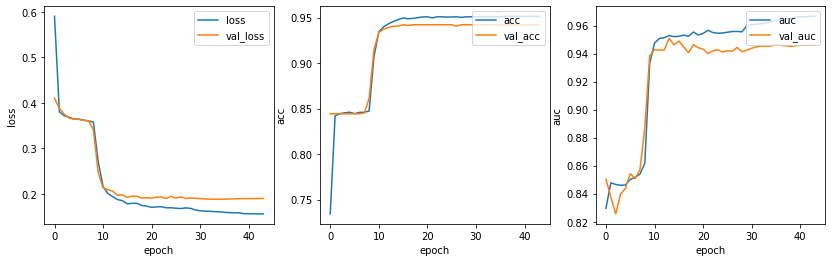

In [56]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [57]:
pred_proba_test, pred_test = eval_metrics(relnn)

test set
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      2592
         1.0       0.91      1.00      0.95      2592

    accuracy                           0.95      5184
   macro avg       0.96      0.95      0.95      5184
weighted avg       0.96      0.95      0.95      5184



In [58]:
log_to_wandb(y_test, pred_proba_test, pred_test)

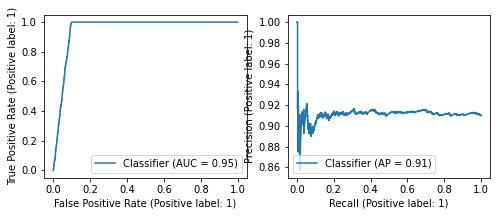

In [59]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

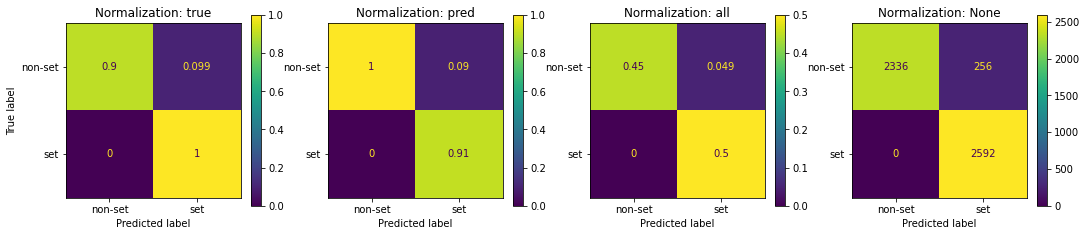

In [60]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [61]:
wandb.finish()

acc,▁▄▅▅▅▅▅▅▅▇██████████████████████████████
auc,▁▂▂▂▂▂▂▂▃▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▄▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁
precision,▁▃▃▃▃▃▃▃▃▆▇█████████████████████████████
recall,▁███████████████████████████████████████
val_acc,▁▁▁▁▁▁▁▁▂▆██████████████████████████████
val_auc,▂▂▁▂▂▃▂▃▄▇██████▇█████▇█▇█▇█████████████
val_loss,█▇▇▇▇▇▆▆▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▁▁▁▁▁▁▂▆██████████████████████████████


### RelNN: MLP Encoder

In [62]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [lambda: MLPEncoder(layer_sizes=(4,), activation='relu')]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           208       
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 834
Trainable params: 834
Non-trainable params: 0
_________________________________________________________________


In [63]:
relnn.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=metrics
    )

In [64]:
run = wandb.init(project='RelNN', group='RelNN (MLP enc)', save_code=True)
history = relnn.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-30 19:02:18.479114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:02:18.479609: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-30 19:02:18.479813: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-30 19:02:18.480556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:02:18.481151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:02:18.481672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 25s 418ms/step - loss: 0.6994 - acc: 0.5733 - precision: 0.5630 - recall: 0.6553 - auc: 0.6372 - val_loss: 0.6871 - val_acc: 0.5744 - val_precision: 0.5604 - val_recall: 0.6934 - val_auc: 0.6028


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 2/100
51/51 [==============================] - 14s 267ms/step - loss: 0.5739 - acc: 0.6791 - precision: 0.6651 - recall: 0.7215 - auc: 0.7540 - val_loss: 0.4496 - val_acc: 0.7957 - val_precision: 0.7500 - val_recall: 0.8875 - val_auc: 0.8254


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 3/100
51/51 [==============================] - 14s 270ms/step - loss: 0.4136 - acc: 0.8188 - precision: 0.7541 - recall: 0.9460 - auc: 0.8377 - val_loss: 0.4042 - val_acc: 0.8350 - val_precision: 0.7526 - val_recall: 0.9985 - val_auc: 0.8192


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 4/100
51/51 [==============================] - 14s 276ms/step - loss: 0.3965 - acc: 0.8288 - precision: 0.7531 - recall: 0.9784 - auc: 0.8354 - val_loss: 0.4241 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8159
Epoch 5/100
51/51 [==============================] - 14s 272ms/step - loss: 0.3907 - acc: 0.8301 - precision: 0.7528 - recall: 0.9827 - auc: 0.8350 - val_loss: 0.4140 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8128
Epoch 6/100
51/51 [==============================] - 13s 262ms/step - loss: 0.3849 - acc: 0.8328 - precision: 0.7531 - recall: 0.9904 - auc: 0.8391 - val_loss: 0.4046 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8155
Epoch 7/100
51/51 [==============================] - 14s 282ms/step - loss: 0.3680 - acc: 0.8463 - precision: 0.7697 - recall: 0.9883 - auc: 0.8577 - val_loss: 0.3530 - val_acc: 0.8666 - val_precision: 0.7895 - val_recall: 1.0000 - val_auc: 0.8663


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 8/100
51/51 [==============================] - 14s 274ms/step - loss: 0.3238 - acc: 0.8700 - precision: 0.7969 - recall: 0.9932 - auc: 0.8913 - val_loss: 0.3375 - val_acc: 0.8751 - val_precision: 0.8002 - val_recall: 1.0000 - val_auc: 0.8838


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 9/100
51/51 [==============================] - 14s 277ms/step - loss: 0.2940 - acc: 0.8886 - precision: 0.8211 - recall: 0.9935 - auc: 0.9133 - val_loss: 0.2742 - val_acc: 0.9036 - val_precision: 0.8394 - val_recall: 0.9985 - val_auc: 0.9117


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 10/100
51/51 [==============================] - 14s 278ms/step - loss: 0.2675 - acc: 0.8992 - precision: 0.8351 - recall: 0.9948 - auc: 0.9250 - val_loss: 0.2675 - val_acc: 0.9059 - val_precision: 0.8418 - val_recall: 1.0000 - val_auc: 0.9223


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 11/100
51/51 [==============================] - 13s 258ms/step - loss: 0.2639 - acc: 0.8989 - precision: 0.8352 - recall: 0.9938 - auc: 0.9281 - val_loss: 0.2652 - val_acc: 0.9052 - val_precision: 0.8407 - val_recall: 1.0000 - val_auc: 0.9206


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 12/100
51/51 [==============================] - 13s 261ms/step - loss: 0.2621 - acc: 0.9008 - precision: 0.8370 - recall: 0.9954 - auc: 0.9288 - val_loss: 0.2673 - val_acc: 0.9052 - val_precision: 0.8416 - val_recall: 0.9985 - val_auc: 0.9250
Epoch 13/100
51/51 [==============================] - 14s 270ms/step - loss: 0.2618 - acc: 0.9011 - precision: 0.8378 - recall: 0.9948 - auc: 0.9293 - val_loss: 0.2637 - val_acc: 0.9067 - val_precision: 0.8429 - val_recall: 1.0000 - val_auc: 0.9225


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 14/100
51/51 [==============================] - 14s 276ms/step - loss: 0.2600 - acc: 0.9009 - precision: 0.8370 - recall: 0.9957 - auc: 0.9300 - val_loss: 0.2613 - val_acc: 0.9059 - val_precision: 0.8418 - val_recall: 1.0000 - val_auc: 0.9294


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 15/100
51/51 [==============================] - 13s 247ms/step - loss: 0.2593 - acc: 0.9006 - precision: 0.8368 - recall: 0.9954 - auc: 0.9310 - val_loss: 0.2712 - val_acc: 0.9052 - val_precision: 0.8424 - val_recall: 0.9969 - val_auc: 0.9174
Epoch 16/100
51/51 [==============================] - 13s 264ms/step - loss: 0.2590 - acc: 0.9003 - precision: 0.8372 - recall: 0.9938 - auc: 0.9311 - val_loss: 0.2646 - val_acc: 0.9059 - val_precision: 0.8418 - val_recall: 1.0000 - val_auc: 0.9267
Epoch 17/100
51/51 [==============================] - 14s 267ms/step - loss: 0.2600 - acc: 0.9011 - precision: 0.8369 - recall: 0.9963 - auc: 0.9301 - val_loss: 0.2587 - val_acc: 0.9075 - val_precision: 0.8440 - val_recall: 1.0000 - val_auc: 0.9270


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 18/100
51/51 [==============================] - 14s 269ms/step - loss: 0.2581 - acc: 0.9003 - precision: 0.8375 - recall: 0.9932 - auc: 0.9318 - val_loss: 0.2693 - val_acc: 0.9059 - val_precision: 0.8427 - val_recall: 0.9985 - val_auc: 0.9247
Epoch 19/100
51/51 [==============================] - 14s 279ms/step - loss: 0.2588 - acc: 0.8998 - precision: 0.8369 - recall: 0.9932 - auc: 0.9317 - val_loss: 0.2683 - val_acc: 0.9052 - val_precision: 0.8424 - val_recall: 0.9969 - val_auc: 0.9216
Epoch 20/100
51/51 [==============================] - 14s 275ms/step - loss: 0.2587 - acc: 0.9003 - precision: 0.8372 - recall: 0.9938 - auc: 0.9315 - val_loss: 0.2616 - val_acc: 0.9059 - val_precision: 0.8427 - val_recall: 0.9985 - val_auc: 0.9249
Epoch 21/100
51/51 [==============================] - 13s 246ms/step - loss: 0.2576 - acc: 0.9003 - precision: 0.8382 - recall: 0.9920 - auc: 0.9327 - val_loss: 0.2619 - val_acc: 0.9067 - val_precision: 0.8429 - val_recall: 1.0000 - val_auc: 0.9247
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 24/100
51/51 [==============================] - 13s 248ms/step - loss: 0.2452 - acc: 0.9025 - precision: 0.8383 - recall: 0.9972 - auc: 0.9408 - val_loss: 0.2488 - val_acc: 0.9090 - val_precision: 0.8462 - val_recall: 1.0000 - val_auc: 0.9336


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 25/100
51/51 [==============================] - 14s 271ms/step - loss: 0.2441 - acc: 0.9029 - precision: 0.8391 - recall: 0.9969 - auc: 0.9417 - val_loss: 0.2488 - val_acc: 0.9090 - val_precision: 0.8462 - val_recall: 1.0000 - val_auc: 0.9338
Epoch 26/100
51/51 [==============================] - 14s 272ms/step - loss: 0.2432 - acc: 0.9034 - precision: 0.8400 - recall: 0.9966 - auc: 0.9424 - val_loss: 0.2486 - val_acc: 0.9098 - val_precision: 0.8473 - val_recall: 1.0000 - val_auc: 0.9341


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 27/100
51/51 [==============================] - 14s 269ms/step - loss: 0.2424 - acc: 0.9040 - precision: 0.8410 - recall: 0.9963 - auc: 0.9428 - val_loss: 0.2487 - val_acc: 0.9098 - val_precision: 0.8473 - val_recall: 1.0000 - val_auc: 0.9339
Epoch 28/100
51/51 [==============================] - 13s 262ms/step - loss: 0.2419 - acc: 0.9045 - precision: 0.8419 - recall: 0.9960 - auc: 0.9431 - val_loss: 0.2484 - val_acc: 0.9106 - val_precision: 0.8484 - val_recall: 1.0000 - val_auc: 0.9340


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 29/100
51/51 [==============================] - 14s 275ms/step - loss: 0.2412 - acc: 0.9051 - precision: 0.8429 - recall: 0.9957 - auc: 0.9436 - val_loss: 0.2485 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9340
Epoch 30/100
51/51 [==============================] - 14s 271ms/step - loss: 0.2407 - acc: 0.9057 - precision: 0.8438 - recall: 0.9957 - auc: 0.9438 - val_loss: 0.2487 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9337
Epoch 31/100
51/51 [==============================] - 14s 275ms/step - loss: 0.2404 - acc: 0.9055 - precision: 0.8438 - recall: 0.9954 - auc: 0.9439 - val_loss: 0.2488 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9338
Epoch 32/100
51/51 [==============================] - 12s 246ms/step - loss: 0.2400 - acc: 0.9055 - precision: 0.8438 - recall: 0.9954 - auc: 0.9440 - val_loss: 0.2489 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9336
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 36/100
51/51 [==============================] - 14s 282ms/step - loss: 0.2375 - acc: 0.9062 - precision: 0.8446 - recall: 0.9954 - auc: 0.9459 - val_loss: 0.2482 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9336


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 37/100
51/51 [==============================] - 14s 269ms/step - loss: 0.2375 - acc: 0.9062 - precision: 0.8446 - recall: 0.9954 - auc: 0.9459 - val_loss: 0.2481 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9337


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 38/100
51/51 [==============================] - 13s 261ms/step - loss: 0.2374 - acc: 0.9062 - precision: 0.8446 - recall: 0.9954 - auc: 0.9459 - val_loss: 0.2481 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9337


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221030_190201-37wp2b06/files/model-best)... Done. 0.1s


Epoch 39/100
51/51 [==============================] - 13s 257ms/step - loss: 0.2373 - acc: 0.9062 - precision: 0.8446 - recall: 0.9954 - auc: 0.9459 - val_loss: 0.2481 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9336
Epoch 40/100
51/51 [==============================] - 15s 291ms/step - loss: 0.2373 - acc: 0.9062 - precision: 0.8446 - recall: 0.9954 - auc: 0.9459 - val_loss: 0.2481 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9335
Epoch 41/100
51/51 [==============================] - 13s 261ms/step - loss: 0.2373 - acc: 0.9062 - precision: 0.8446 - recall: 0.9954 - auc: 0.9459 - val_loss: 0.2481 - val_acc: 0.9106 - val_precision: 0.8493 - val_recall: 0.9985 - val_auc: 0.9335

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 42/100
51/51 [==============================] - 13s 252ms/step - loss: 0.2371 - acc: 0.9063 - precision: 0.8447 - recall: 0.9957 - auc: 0.9461 - val_loss: 0.2481 - va

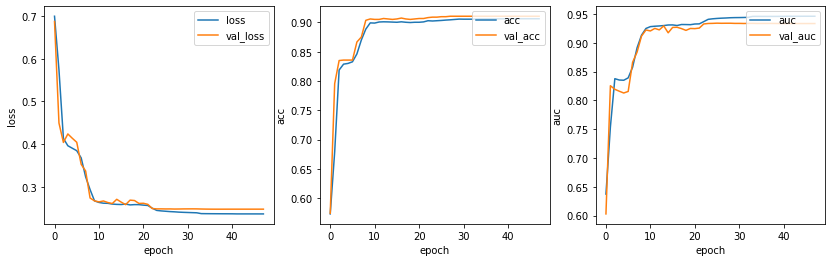

In [65]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [66]:
pred_proba_test, pred_test = eval_metrics(relnn)

test set


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89      2592
         1.0       0.84      0.99      0.91      2592

    accuracy                           0.90      5184
   macro avg       0.92      0.90      0.90      5184
weighted avg       0.92      0.90      0.90      5184



In [67]:
log_to_wandb(y_test, pred_proba_test, pred_test)

wandb: ERROR Error while calling W&B API: failed to find project awni00/RelNN (<Response [404]>)
Exception in thread Thread-112:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/wandb/apis/normalize.py", line 25, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/internal_api.py", line 1477, in upload_urls
    run = query_result["model"]["bucket"]
TypeError: 'NoneType' object is not subscriptable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/wandb/filesync/upload_job.py", line 62, in run
    success = self.push()
  File "/opt/conda/lib/python3.7/site-packages/wandb/filesync/upload_job.py", line 113, in push
    _, upload_headers, result = self._api.upload_urls(project, [self.save_name])
  File "/opt/

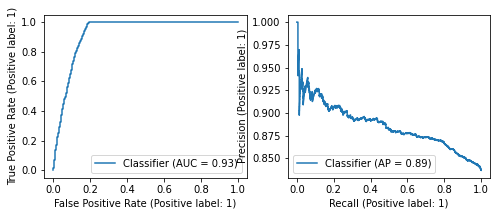

In [68]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

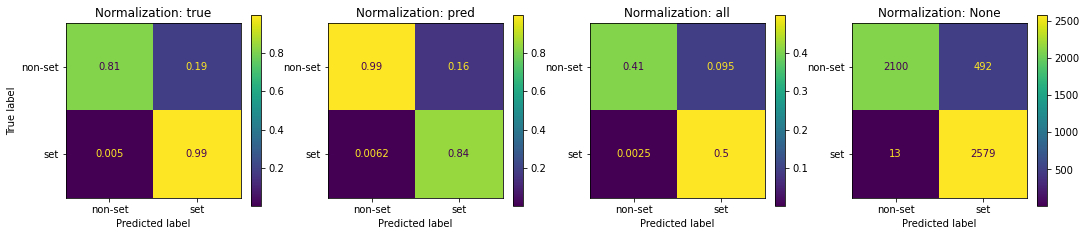

In [69]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [70]:
wandb.finish()

wandb: ERROR Error while calling W&B API: failed to find project awni00/RelNN (<Response [404]>)


acc,▁▃▆▆▆▇▇█████████████████████████████████
auc,▁▄▆▅▅▆▇▇████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▄▆▆▆▆▇▇████████████████████████████████
recall,▁▂▇█████████████████████████████████████
val_acc,▁▆▆▆▆▇▇█████████████████████████████████
val_auc,▁▆▆▆▅▇▇█████████████████████████████████
val_loss,█▄▃▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▆▆▆▆▇▇█████████████████████████████████


## Notes

**Observations:**
- (O1) RelNN sometimes gets stuck at high loss for a while and then finds a way to escape it during training. (Note: used Adam on RelNN's instead of SGD because of this!)

**To-Do's:**
- (TD1) come up with systematic experimental methodology to run broader set of experiments on in order to make fair comparisons.
- (TD2) CoRelNet (and other ESBN) use TCN. read paper. add to experiments and observe effects.
- (TD3) add spurious features. observe effect on each set of models.
- (TD4) implement grouping layer and test on appropriate task (e.g.: ABA task, etc.)
- (TD5) clean up some of the repetitive code

**Questions:**
- (Q1) why can CoRelNet predict?
    - with the encoding we're using, each pairwise relation is the number of attributes shared by the two entities. is this enough to predict 'setness'?
        - compute the set of relation matrices for all sets and non-sets and see if there is an example both sets and non-sets have the same relation matrix...
- (Q2) how do linear projection vs MLP encoders compare?
- (Q3) what effect exactly did the 'good initialization' of the linear projection spaces have on RelNN?
- (Q4) on O1: is there anything we can infer about the loss landscape for such models that might explain this?
